# Librairies & Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import glob
from scipy import ndimage
import time
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from skimage.transform import resize

smooth = 1e-3
#from skimage import morphology

volumes_path = "data/volumes"
#labels_path = "data/labels"

img_type = "mhd"
np.set_printoptions(threshold=np.inf)

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing


# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def create_numpy_labels(labels_path, view):
    start_time = time.time()
    labels_list = glob.glob(labels_path+"/*."+img_type)
    labels_list.sort()
    #print(labels_list)

    #Create a numpy array. It will contain every slices of all labels.
    numpy_labels = np.ndarray((0,128,128,1), dtype=np.uint8)
    labels_shape = np.ndarray((len(labels_list),3), dtype=np.uint16)
    #index of the slice position
    index = 0
    index_2 = 0
    
    for label_name in labels_list :
    
        #mri_scan is the 3D label converted in numpy array
        (mri_scan, origin, spacing) = load_itk(label_name)
        labels_shape[index_2] = mri_scan.shape
        index_2 +=1
        if(view == 'coronnal'):
            label_3d = np.transpose(mri_scan, (2, 1, 0))
        elif(view == 'axial'):
            label_3d = np.transpose(mri_scan, (1, 0, 2))
        elif(view == 'sagittal'):
            label_3d = mri_scan
        else:
            print('Vue non renseignee')
            
        #increase the size of numpy_labels corresponding to the 3d label processed in this loop
        numpy_labels = np.lib.pad(numpy_labels, ((0,label_3d.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
    
        #We resize every slices and put them into numpy_volumes
        for i in range(0,label_3d.shape[0]):
        
            mri_slice_res = cv2.resize(label_3d[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        
            mask1 = mri_slice_res == 2
            mri_slice_res[mask1] = 0

            mask2 = mri_slice_res == 4
            mri_slice_res[mask2] = 0

            mask3 = mri_slice_res == 1
            mri_slice_res[mask3] = 255

            mask4 = mri_slice_res == 3
            mri_slice_res[mask4] = 0
        
            #Ouverture pour enlever les defauts apparus lors du redimensionnement
            mri_slice_res = ndimage.binary_opening(mri_slice_res, structure=np.ones((3,3))).astype(int)
            #mri_slice_res = ndimage.remove_small_objects(mri_slice_res, 8)
        
            mask5 = mri_slice_res == 1
            mri_slice_res[mask5] = 255
        
            mri_slice_res = mri_slice_res[..., np.newaxis]

            numpy_labels[i + index] = mri_slice_res

        
    
        index = index + label_3d.shape[0]

    
    print('Shape of the labels numpy array : ',numpy_labels.shape)
    print('Type of the array is : ',numpy_labels.dtype)
    print("Time to process --- %s seconds ---" % (time.time() - start_time))
    
    return numpy_labels, labels_shape


def create_numpy_volumes(volumes_path, view):
    start_time = time.time()
    
    #Create a list of each volume's path
    volumes_list = glob.glob(volumes_path+"/*."+img_type)
    volumes_list.sort()

    #Create a numpy array. It will contain every slices of all volumes.
    numpy_volumes = np.ndarray((0,128,128,1), dtype=np.uint8)
    volumes_shape = np.ndarray((len(volumes_list),3), dtype=np.uint16)

    #index of the slice position
    index = 0
    index_2 = 0

    for volume_name in volumes_list :
        #mri_scan is the volume converted in numpy array
        (mri_volume, origin, spacing) = load_itk(volume_name)
        
        volumes_shape[index_2] = mri_volume.shape
        index_2 +=1
        
        if(view == 'coronnal'):
            mri_volume = np.transpose(mri_volume, (2, 1, 0))
        elif(view == 'axial'):
            mri_volume = np.transpose(mri_volume, (1, 0, 2))
        elif(view == 'sagittal'):
            mri_volume = mri_volume
        else:
            print('Vue non renseignee')

    
    
        mri_volume = 255 / np.amax(mri_volume) * mri_volume
    
        mri_volume = mri_volume.astype('uint8')

    
        #increase the size of numpy_volumes corresponding to the volume processed in this loop
        numpy_volumes = np.lib.pad(numpy_volumes, ((0,mri_volume.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
    
        #We resize every slices and put them into numpy_volumes
        for i in range(0,mri_volume.shape[0]):
        
            mri_slice_res = cv2.resize(mri_volume[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            mri_slice_res = mri_slice_res[..., np.newaxis]
            
        
        
            numpy_volumes[i + index] = mri_slice_res

        
    
        index = index + mri_volume.shape[0]
    

    
    
    print('Shape of the volumes numpy array : ',numpy_volumes.shape)
    print('Type of the array is : ',numpy_volumes.dtype)
    print("Time to process --- %s seconds ---" % (time.time() - start_time))
    
    return numpy_volumes, volumes_shape

class myUnet(object):

	def __init__(self, img_rows = 128, img_cols = 128):

		self.img_rows = img_rows
		self.img_cols = img_cols

	def load_data(self):

		mydata = dataProcess(self.img_rows, self.img_cols)
		imgs_train, imgs_mask_train = mydata.load_train_data()
		imgs_test = mydata.load_test_data()
		return imgs_train, imgs_mask_train, imgs_test

	def get_unet(self):

		inputs = Input((self.img_rows, self.img_cols,1))
		

		conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
		print ("conv1 shape:",conv1.shape)
		conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
		print ("conv1 shape:",conv1.shape)
		#norm1 = BatchNormalization(axis=-1)
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		print ("pool1 shape:",pool1.shape)

		conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
		print ("conv2 shape:",conv2.shape)
		conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
		print ("conv2 shape:",conv2.shape)
		#norm2 = BatchNormalization(axis=-1)
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		print ("pool2 shape:",pool2.shape)

		conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
		print ("conv3 shape:",conv3.shape)
		conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
		print ("conv3 shape:",conv3.shape)
		#norm3 = BatchNormalization(axis=-1)
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		print ("pool3 shape:",pool3.shape)

		conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
		conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)
		pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

		conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
		conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
		drop5 = Dropout(0.5)(conv5)

		up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
		merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

		up7 = Conv2D(256, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
		merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
		conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
		conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

		up8 = Conv2D(128, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
		conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
		conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

		up9 = Conv2D(64, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
		conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
		conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		conv9 = Conv2D(2, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)




        
		conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

		model = Model(input = inputs, output = conv10)
        
		#model_dice = dice_loss(smooth=1e-5, thresh=0.9)
        
		#model.compile(optimizer = SGD(lr=0.0001, momentum=0.002, decay=0.002, nesterov=True), loss = 'binary_crossentropy', metrics = ['accuracy'])
		#model.compile(optimizer = RMSprop(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
		model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])

		return model


	def train(self):

		print("loading data")
		imgs_train, imgs_mask_train, imgs_test = self.load_data()
		print("loading data done")
		model = self.get_unet()
		#print(model.summary())
		#print("MODEL ENREGISTRE")
		print("got unet")

		#model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
        
        # checkpoint
		filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
		model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
		callbacks_list = [model_checkpoint]
		print('Fitting model...')
		history = model.fit(imgs_train, imgs_mask_train, batch_size=32, nb_epoch=150, verbose=1,validation_split=0.15, shuffle=True, callbacks=callbacks_list)
		#rint('Fitting model...')
		#history = model.fit(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=5, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

		print(history.history.keys())
		
		# summarize history for accuracy
		plt.plot(history.history['dice_coef'])
		plt.plot(history.history['val_dice_coef'])
		plt.title('model accuracy')
		plt.ylabel('Dice')
		plt.xlabel('epoch')
		plt.legend(['train', 'validation'], loc='upper left')
		plt.show()
		
		# summarize history for loss
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.title('model loss')
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.legend(['train', 'validation'], loc='upper left')
		plt.show()
		
		
		
		print('predict test data')
		imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
		np.save('results/imgs_mask_test.npy', imgs_mask_test)

	def save_img(self):

		print("array to image")
		imgs = np.load('results/imgs_mask_test.npy')
		for i in range(imgs.shape[0]):
			img = imgs[i]
			img = array_to_img(img)
			img.save("results/%d.jpg"%(i))

D:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import and pre-process volumes

In [10]:
volumes_coronal, volumes_shape = create_numpy_volumes('data/test3d', 'coronnal')
volumes_axial, volumes_shape  = create_numpy_volumes('data/test3d', 'axial')
volumes_sagittal, volumes_shape = create_numpy_volumes('data/test3d', 'sagittal')

volumes_coronal = volumes_coronal.astype('float32')
volumes_axial = volumes_axial.astype('float32')
volumes_sagittal = volumes_sagittal.astype('float32')

volumes_coronal /= 255
volumes_axial /= 255
volumes_sagittal /= 255

Shape of the volumes numpy array :  (295, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.1334543228149414 seconds ---
Shape of the volumes numpy array :  (363, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.10934948921203613 seconds ---
Shape of the volumes numpy array :  (112, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.10076332092285156 seconds ---


# Predict Labels

In [11]:
start_time = time.time()
myunet = myUnet()

model = myunet.get_unet()

model.load_weights('sagittal-network-ns.hdf5')
calculated_labels_sagittal = model.predict(volumes_sagittal, verbose=1)

model.load_weights('coronal-network-ns.hdf5')
calculated_labels_coronal = model.predict(volumes_coronal, verbose=1)

model.load_weights('axial-network-ns.hdf5')
calculated_labels_axial = model.predict(volumes_axial, verbose=1)

print("Time to process --- %s seconds ---" % (time.time() - start_time))

conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
pool1 shape: (?, 64, 64, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
pool2 shape: (?, 32, 32, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)
pool3 shape: (?, 16, 16, 256)


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:246: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:251: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:256: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ip

363/363 [==============================] - 3s 8ms/step
Time to process --- 8.319488763809204 seconds ---


# Resize and transpose volumes

D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


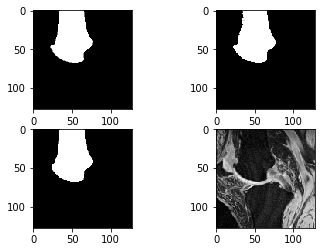

In [12]:
labels_coronal_rs = resize(calculated_labels_coronal, (128, 128, 128), anti_aliasing=False)
labels_coronal_tr = np.transpose(labels_coronal_rs[:,:,:,0], (2, 1, 0))


labels_axial_rs = resize(calculated_labels_axial, (128, 128, 128), anti_aliasing=False)
labels_axial_tr = np.transpose(labels_axial_rs[:,:,:,0], (1, 0, 2))


labels_sagittal_rs = resize(calculated_labels_sagittal, (128, 128, 128), anti_aliasing=False)
labels_sagittal_rs = labels_sagittal_rs[:,:,:,0]

volumes_sagittal_rs = resize(volumes_sagittal, (128, 128, 128))
volumes_sagittal_rs = volumes_sagittal_rs[:,:,:,0]

slice = 60

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(labels_sagittal_rs[slice], cmap='gray')
f.add_subplot(2,2, 2)
plt.imshow(labels_axial_tr[slice], cmap='gray')
f.add_subplot(2,2, 3)
plt.imshow(labels_coronal_tr[slice], cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow(volumes_sagittal_rs[slice], cmap='gray')
plt.show(block=True)

# Combine results and saves labels

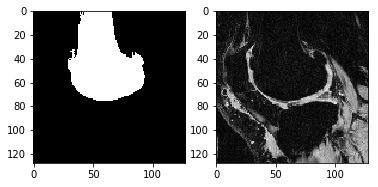

In [64]:
slice = 80

labels_combined = labels_sagittal_rs + labels_axial_tr + labels_coronal_tr

upper = 100
lower = 0
threshold = 1.5
labels_combined_bn = np.where(labels_combined>threshold, upper, lower)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(labels_combined_bn[slice], cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(volumes_sagittal_rs[slice], cmap='gray')
plt.show(block=True)


labels_combined_bn = labels_combined_bn.astype('float32')
volumes_sagittal_rs = volumes_sagittal_rs.astype('float32')

labels_combined_image = sitk.GetImageFromArray(labels_combined_bn)
sitk.WriteImage(labels_combined_image, "test_combined_labels_v87_ns.tif")

volumes_sagittal_image = sitk.GetImageFromArray(volumes_sagittal_rs)
sitk.WriteImage(volumes_sagittal_image, "test_volumes_v87_ns.tif")

In [65]:
labels_ski10, labels_shape = create_numpy_labels('data/test3d/labels', 'sagittal')


# upper = 100
# lower = 0
# threshold = 150
# labels_ski10 = np.where(labels_ski10[:,:,:,0]>threshold, upper, lower)
# plt.imshow(labels_ski10[slice], cmap='gray')

labels_ski10 = resize(labels_ski10, (128, 128, 128), anti_aliasing=False)






upper = 100
lower = 0
threshold = 0.5
labels_ski10 = np.where(labels_ski10[:,:,:,0]>threshold, upper, lower)

labels_ski10 = labels_ski10.astype('float32')


labels_ski10_image = sitk.GetImageFromArray(labels_ski10)
sitk.WriteImage(labels_ski10_image, "test_labels_ski10_v87.tif")



Shape of the labels numpy array :  (104, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.062451839447021484 seconds ---


D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


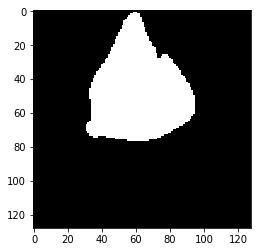

In [51]:
upper = 100
lower = 0
threshold = 0.5
labels_sagittal_bn = np.where(labels_sagittal_rs>threshold, upper, lower)

labels_sagittal_bn = labels_sagittal_bn.astype('float32')

plt.imshow(labels_sagittal_bn[slice], cmap='gray')

labels_sagittal_image = sitk.GetImageFromArray(labels_sagittal_bn)
#sitk.WriteImage(labels_sagittal_image, "test_sagittal_labels_v1_ns.tif")

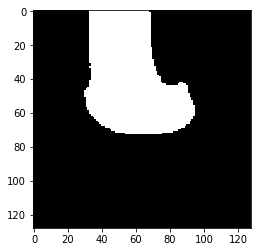

In [76]:
upper = 100
lower = 0
threshold = 0.5
labels_coronal_bn = np.where(labels_coronal_tr>threshold, upper, lower)

labels_coronal_bn = labels_coronal_bn.astype('float32')

plt.imshow(labels_coronal_bn[slice], cmap='gray')

labels_coronal_image = sitk.GetImageFromArray(labels_coronal_bn)
sitk.WriteImage(labels_coronal_image, "test_coronal_labels_v38.tif")

# DICE calculation

In [66]:
upper = 1
lower = 0
threshold = 0.5
labels_combined_bn = np.where(labels_combined_bn>threshold, upper, lower)
labels_ski10 = np.where(labels_ski10>threshold, upper, lower)
labels_sagittal_bn = np.where(labels_sagittal_rs>threshold, upper, lower)


dice = np.sum(labels_combined_bn[labels_ski10==1])*2.0 / (np.sum(labels_combined_bn) + np.sum(labels_ski10))
dice2 = np.sum(labels_sagittal_bn[labels_ski10==1])*2.0 / (np.sum(labels_sagittal_bn) + np.sum(labels_ski10))
print('Combined Dice similarity score is {}'.format(dice))
print('Sagittal Dice similarity score is {}'.format(dice2))

Combined Dice similarity score is 0.9563865723507601
Sagittal Dice similarity score is 0.951631844086872
